###**Preparing the dataset**

Prepare the dataset using Labelme annotation tool (for Instance segmentation) and LabelImg for object detection.


In [72]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


###**Installing Detectron2 on Colab**

In [73]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [74]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# After this step it will ask you to restart the runtime, please do it.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [75]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2
import os

###**Register the data to Detectron2 config**

In [76]:
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer

In [77]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 224
        record["width"] = 224
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [78]:


data_path = '/content/drive/MyDrive/CS3244 data/new data in coco/'

from detectron2.data.datasets import register_coco_instances
register_coco_instances("train", {}, data_path+"labels/train.json", data_path+"images/train/")
register_coco_instances("test", {}, data_path+"labels/test.json", data_path+"images/test/")
register_coco_instances("val", {}, data_path+"labels/val.json", data_path+"images/val/")


AssertionError: ignored

WARNING [04/15 11:36:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 11:36:27 d2.data.datasets.coco]: Loaded 1231 images in COCO format from /content/drive/MyDrive/CS3244 data/new data in coco/labels/train.json


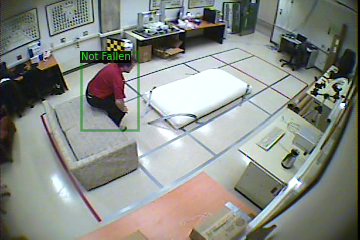

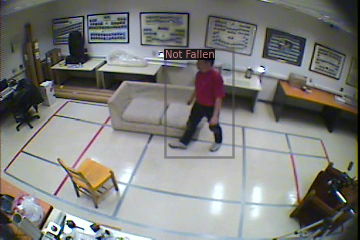

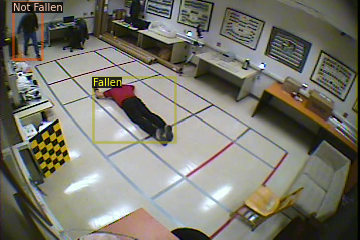

In [79]:
##for visualisation
from google.colab.patches import cv2_imshow
my_dataset_train_metadata = MetadataCatalog.get("train")
dataset_dicts = DatasetCatalog.get("train")
classes = ['Fallen','Not Fallen']
import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

###**Training the Detectron2 Instance Segmentation Model**

In [80]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

In [81]:
##backbone used is resnet-101
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("val",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00001
cfg.OUTPUT_DIR='drive/MyDrive/CS3244 data/Model/'

cfg.SOLVER.WARMUP_ITERS = 300
cfg.SOLVER.MAX_ITER = 4000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3

cfg.TEST.EVAL_PERIOD = 500



In [82]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
cfg.MODEL.WEIGHTS='drive/MyDrive/CS3244 data/Model/model_final.pth'
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)

[04/15 11:36:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

AssertionError: ignored

In [ ]:
trainer.train()

[04/15 08:41:16 d2.engine.train_loop]: Starting training from iteration 3000
[04/15 08:42:27 d2.utils.events]:  eta: 0:59:28  iter: 3019  total_loss: 0.3822  loss_cls: 0.05605  loss_box_reg: 0.3147  loss_rpn_cls: 2.362e-06  loss_rpn_loc: 0.004418  time: 3.5613  data_time: 0.0194  lr: 1e-05  max_mem: 6980M
[04/15 08:43:37 d2.utils.events]:  eta: 0:58:12  iter: 3039  total_loss: 0.3233  loss_cls: 0.05476  loss_box_reg: 0.2365  loss_rpn_cls: 2.253e-06  loss_rpn_loc: 0.002974  time: 3.5329  data_time: 0.0089  lr: 1e-05  max_mem: 6980M
[04/15 08:44:48 d2.utils.events]:  eta: 0:56:58  iter: 3059  total_loss: 0.3144  loss_cls: 0.07687  loss_box_reg: 0.2376  loss_rpn_cls: 2.863e-06  loss_rpn_loc: 0.002848  time: 3.5354  data_time: 0.0074  lr: 1e-05  max_mem: 6980M
[04/15 08:46:01 d2.utils.events]:  eta: 0:55:46  iter: 3079  total_loss: 0.3888  loss_cls: 0.05749  loss_box_reg: 0.302  loss_rpn_cls: 5.254e-06  loss_rpn_loc: 0.003831  time: 3.5671  data_time: 0.0091  lr: 1e-05  max_mem: 6980M
[04/

###**Inference using the Trained Model**

In [99]:
from detectron2.checkpoint import DetectionCheckpointer
cfg.MODEL.WEIGHTS='drive/MyDrive/CS3244 data/Model/model_final_10k.pth'  # load a file, usually from cfg.MODEL.WEIGHTS
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 
predictor = DefaultPredictor(cfg)

In [84]:
test_pth=os.path.join('drive/MyDrive/CS3244 data/new data in coco/images/test/')
test_img_list=os.listdir(test_pth)
test_img_list

['Chute 23anglesix05041.jpg',
 'Chute 17anglefour00481.jpg',
 'Chute 4angletwo00361.jpg',
 'Chute 1anglefive00001.jpg',
 'Chute 17angleone01201.jpg',
 'Chute 13angleseven01081.jpg',
 'Chute 21anglethree00721.jpg',
 'Chute 23anglefour00961.jpg',
 'Chute 5anglefive00481.jpg',
 'Chute 8anglefour00001.jpg',
 'Chute 23angleeight03241.jpg',
 'Chute 16anglefive00721.jpg',
 'Chute 15angleone00001.jpg',
 'Chute 5angleseven00001.jpg',
 'Chute 11anglefour00601.jpg',
 'Chute 9angleone00841.jpg',
 'Chute 19anglefive00841.jpg',
 'Chute 24anglefour02881.jpg',
 'Chute 22angleeight00481.jpg',
 'Chute 7angleseven00361.jpg',
 'Chute 23angleeight02761.jpg',
 'Chute 14anglesix00721.jpg',
 'Chute 23anglethree01201.jpg',
 'Chute 6angletwo00721.jpg',
 'Chute 10angleseven00601.jpg',
 'Chute 9angletwo00361.jpg',
 'Chute 14angleeight00721.jpg',
 'Chute 23angleone01321.jpg',
 'Chute 24anglefour00601.jpg',
 'Chute 24angleeight02401.jpg',
 'Chute 14anglefive00361.jpg',
 'Chute 23angleone04201.jpg',
 'Chute 22angles

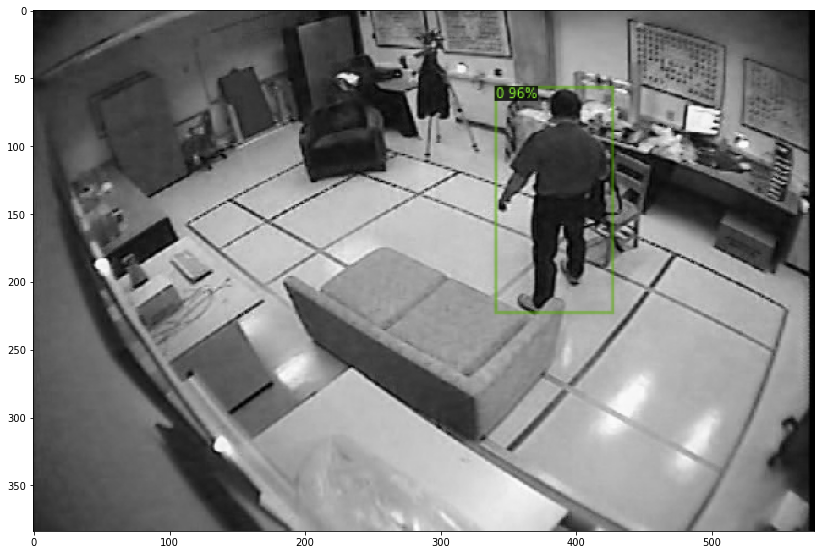

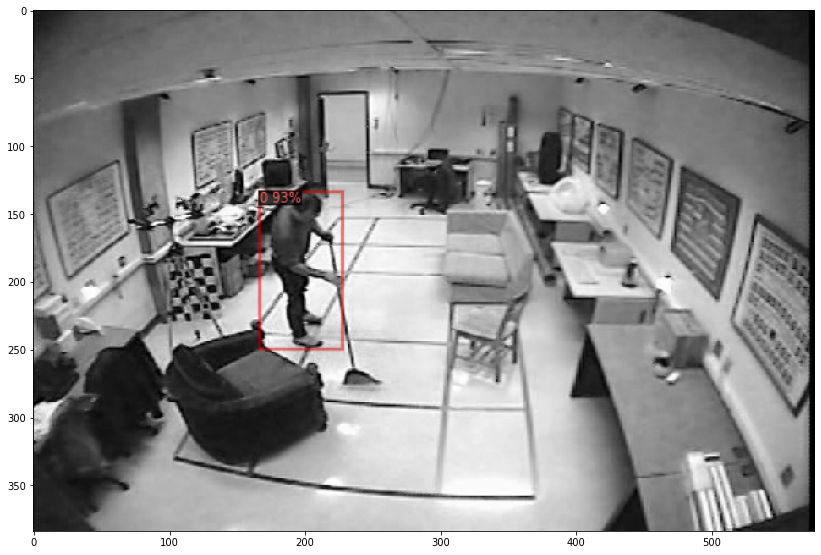

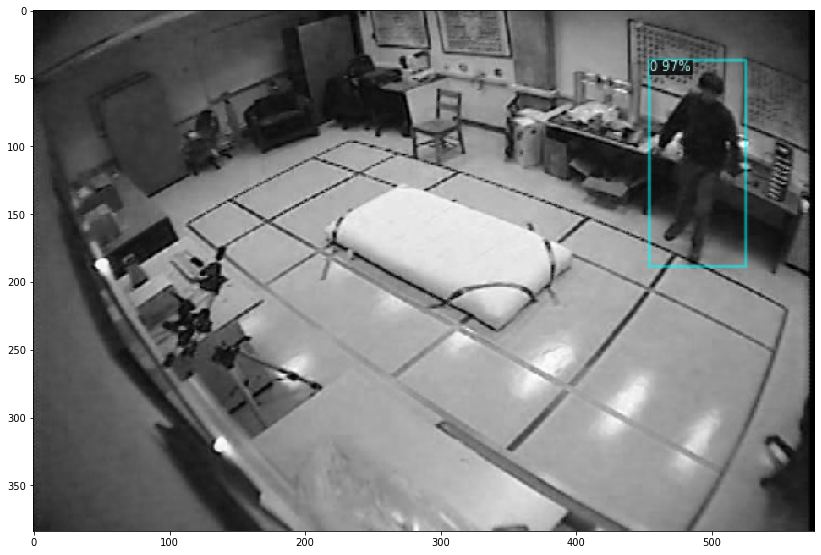

In [85]:
test_metadata = MetadataCatalog.get("my_dataset_test")
for d in random.sample(test_img_list, 3):    
    img = cv2.imread(os.path.join(test_pth,d))
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=test_metadata,
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [100]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("val", output_dir="./output")
test_loader = build_detection_test_loader(cfg, "val")
print(inference_on_dataset(predictor.model, test_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [04/15 11:56:55 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 11:56:55 d2.data.datasets.coco]: Loaded 176 images in COCO format from /content/drive/MyDrive/CS3244 data/new data in coco/labels/val.json
[04/15 11:56:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/15 11:56:56 d2.data.common]: Serializing 176 elements to byte tensors and concatenating them all ...
[04/15 11:56:56 d2.data.common]: Serialized dataset takes 0.05 MiB
[04/15 11:56:56 d2.evaluation.evaluator]: Start inference on 176 batches
[04/15 11:57:04 d2.evaluation.evaluator]: Inference done 11/176. Dataloading: 0.0021 s/iter. Inference: 0.7534 s/iter. Eval: 0.0003 s/iter. Total: 0.7558 s/iter. ETA=0:02:04
[04/15 11:57:10 d2.evaluation.evaluator]: Inference done 18/176. Dataloading: 0.0021 s/iter. Inference: 0.7530 s/iter.

In [29]:
trainer.test(cfg, cfg.MODEL.WEIGHTS)

WARNING [04/15 10:02:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/15 10:02:12 d2.data.datasets.coco]: Loaded 176 images in COCO format from /content/drive/MyDrive/CS3244 data/new data in coco/labels/val.json
[04/15 10:02:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/15 10:02:12 d2.data.common]: Serializing 176 elements to byte tensors and concatenating them all ...
[04/15 10:02:12 d2.data.common]: Serialized dataset takes 0.05 MiB
WARNING [04/15 10:02:12 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.


{}